# Network partitioning - synthetic data
---

## Imports
---

In [1]:
import networkx as nx
import pandas as pd
#import numpy as np
import matplotlib.pyplot as plt
import os
import math
import pickle
import osmnx as ox
import geopandas as gpd 
import momepy

%matplotlib inline

## Cleaning function

In [2]:
def process_lines_polygons(polygon_data, network_data):
    '''
    reads in:
            - shapefile of polygons
            - shapefile of network
    
    returns dictionary where keys are equal to the shp file name:
            - dataframe of attributes
            - adjacency matrix of network (nodes are equal to X/Y coordinate)
    '''
    
    gdf = polygon_data
    network = network_data
    
    network = network.set_crs('epsg:2039')
    gdf = gdf.to_crs('epsg:2039')
    gdf = gdf.set_index('id')
    
    subgraphs = {}
    for index, polygon in gdf.iterrows():
        clipped = network.clip(polygon['geometry'])
        clipped = clipped[~clipped.is_empty]    
        subgraphs[index] = clipped
    
    subgraphs_nx = {}
    for i in subgraphs:
        subgraphs_nx[i] = momepy.gdf_to_nx(subgraphs[i], approach="primal")
        
    sub_graphs_dict = {}
    for key, value in subgraphs_nx.items():
        sub_graphs_dict[key] = pd.DataFrame(nx.adjacency_matrix(subgraphs_nx[key], nodelist=sorted(subgraphs_nx[key].nodes())).todense(), 
                 index = sorted(subgraphs_nx[key].nodes()),
                columns = sorted(subgraphs_nx[key].nodes()))
    
    return(gdf, sub_graphs_dict)

## Data
---

In [3]:
gdf = gpd.read_file("shp_files/polygons/polygon_merged_2.shp")

In [4]:
#ofer_network = gpd.read_file("shp_files/StreetNetwork")

In [5]:
directory = 'shp_files'

dicty = {}

for folder in os.listdir(directory):
    if folder == 'polygons' or folder == 'StreetNetwork':
        continue
    else:    
        shp = os.path.join(directory, folder).replace("\\","/")
        print(shp)
        network = gpd.read_file(shp)
        dicty[folder] = process_lines_polygons(gdf, network)

shp_files/K1D1
shp_files/K1D2
shp_files/K1D3
shp_files/K1D4
shp_files/K2D1
shp_files/K2D2
shp_files/K2D3
shp_files/K2D4
shp_files/K3D1
shp_files/K3D2
shp_files/K3D3
shp_files/K3D4
shp_files/K4D1
shp_files/K4D2
shp_files/K4D3
shp_files/K4D4
shp_files/K5D1
shp_files/K5D2
shp_files/K5D3
shp_files/K5D4


In [6]:
dicty.keys()

dict_keys(['K1D1', 'K1D2', 'K1D3', 'K1D4', 'K2D1', 'K2D2', 'K2D3', 'K2D4', 'K3D1', 'K3D2', 'K3D3', 'K3D4', 'K4D1', 'K4D2', 'K4D3', 'K4D4', 'K5D1', 'K5D2', 'K5D3', 'K5D4'])

## Example print outs

<AxesSubplot:>

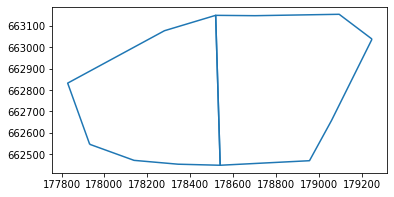

In [7]:
# boundary plot - used for partitioning graph
dicty['K1D4'][0].boundary.plot()

In [8]:
# polygon data for areas 1 and 2
dicty['K1D4'][0]

,GEO_CODE,Age_Mean,Age_Median,Population,Shared_dwe,Unshared_d,Unshared_W,Unshared_F,One_person,One_family,...,one_car,two_cars,three_cars,four_plus_,Owned_tenu,Social_ren,Private_re,Males,Females,geometry
id,,,,,,,,,,,,,,,,,,,,,
1,1,42.10929,42,1592,0,795,637,158,350,406,...,363,130,15,5,1076,180,293,795,797,"POLYGON ((179249.107 663037.803, 179059.946 66..."
2,2,40.15316,39,1678,0,768,585,183,286,429,...,383,154,32,11,1221,85,350,815,863,"POLYGON ((177931.499 662546.960, 177828.765 66..."


In [9]:
# adjacency matrix of subgraph 1
dicty['K1D4'][1][1].head(2)

,"(178520.32257598138, 663117.1581036729)","(178520.33740133612, 663116.6688845278)","(178520.6668666197, 663105.7969204384)","(178523.25113504048, 663020.5191237493)","(178527.34020505412, 662885.5846570106)","(178530.1216666306, 663019.7235651296)","(178530.3898897355, 663021.5464176465)","(178531.7983875525, 662738.469915508)","(178534.94835038585, 662634.5248732979)","(178539.6933012162, 662634.2787165771)",...,"(178978.1747814609, 663039.5419759592)","(178991.47668675464, 663104.3969367769)","(178995.70565437636, 662613.1205964147)","(179022.72296005208, 662673.8242697803)","(179060.0626991988, 662740.636097501)","(179076.70704937892, 663129.3386879673)","(179091.23108425358, 662809.5218262211)","(179125.139843337, 662877.0298339411)","(179167.2839934806, 662943.8217018828)","(179209.50852678617, 663031.1102697516)"
"(178520.32257598138, 663117.1581036729)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(178520.33740133612, 663116.6688845278)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# adjacency matrix of subgraph 2
dicty['K1D4'][1][2].head(2)

,"(177860.6122030813, 662821.6432968262)","(177898.71939870354, 662738.1300921106)","(177921.0948698273, 662753.3269029348)","(177931.32295305957, 662862.4357922911)","(177931.3541882501, 662659.4215335724)","(177947.46729710387, 662569.8473603032)","(177951.3736358846, 662539.7608969779)","(177955.4507146086, 662735.1370649197)","(177956.366399838, 662732.0021013496)","(177964.7275672707, 662804.2229362131)",...,"(178515.40610313485, 663116.4612034198)","(178516.4710354481, 663106.9916491092)","(178520.32257598138, 663117.1581036729)","(178520.33740133612, 663116.6688845278)","(178520.6668666197, 663105.7969204384)","(178523.25113504048, 663020.5191237493)","(178527.34020505412, 662885.5846570106)","(178531.7983875525, 662738.469915508)","(178534.94835038585, 662634.5248732979)","(178540.11591331926, 662464.001417737)"
"(177860.6122030813, 662821.6432968262)",0,1,0,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
"(177898.71939870354, 662738.1300921106)",1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Load data from pickle

In [12]:
pickle.dump(dicty, open("pickle/dicty.p", "wb"))

In [13]:
graphs_dict = pickle.load(open("pickle/dicty.p", "rb"))